## Célula 1: Configuração e Bibliotecas
Nesta etapa, realizamos a configuração inicial do ambiente:
1.  **Importações:** Carregamento das bibliotecas essenciais como PyTorch (treinamento), Torchvision (datasets e modelos), Scikit-learn (métricas e split) e Matplotlib (visualização).
2.  **Reprodutibilidade:** Definição de uma semente (seed `42`) para garantir que a inicialização dos pesos e a divisão dos dados sejam as mesmas em toda execução.
3.  **Infraestrutura:** Definição dos caminhos dos dados usando `pathlib` (para compatibilidade entre SOs) e verificação automática do dispositivo (GPU/CUDA ou CPU).

In [1]:
import os
import random
from pathlib import Path
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, Dataset
import torchvision
from torchvision import transforms, models, datasets

from sklearn.metrics import (accuracy_score, precision_recall_fscore_support,
                             multilabel_confusion_matrix, classification_report,
                             hamming_loss)

SEED = 42
DATA_ROOT = Path('.')
SINGLE_DIR = DATA_ROOT / 'Imagens_um_Alimento_Processadas'
VARIOS_DIR = DATA_ROOT / 'Imagens_Varios_Alimentos_Processadas'
OUTPUT_DIR = Path('outputs_multilabel')
OUTPUT_DIR.mkdir(exist_ok=True)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
NUM_WORKERS = 0

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

print('Dispositivo:', DEVICE)
print('Diretórios com fotos de um alimento existe?', SINGLE_DIR.exists())
print('Diretório com fotos de vários alimentos misturados existe?', VARIOS_DIR.exists())

Dispositivo: cuda
Diretórios com fotos de um alimento existe? True
Diretório com fotos de vários alimentos misturados existe? True


## Célula 2: Funções Auxiliares e Dataset Customizado
Aqui definimos ferramentas fundamentais para o pipeline de dados:
1.  **`imshow_tensor`:** Função para visualização. Ela reverte a normalização da ImageNet (média e desvio padrão) para que as imagens possam ser exibidas corretamente com o Matplotlib.
2.  **`MultiLabelFolder`:** Uma classe personalizada herdada de `torch.utils.data.Dataset`.
    * Diferente do `ImageFolder` padrão, ela é projetada para ler um DataFrame onde uma imagem pode ter múltiplos rótulos.
    * Converte os rótulos em um vetor **Multi-Hot Encoding** (vetor de zeros e uns), essencial para o cálculo da perda em classificação multilabel.

In [2]:
def imshow_tensor(tensor, title=None):
    inv_norm = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )
    img = inv_norm(tensor)
    img = img.permute(1,2,0).cpu().numpy()
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis('off')

class MultiLabelFolder(Dataset):
    def __init__(self, dataframe, root_dir, transform=None, class_to_idx=None):
        self.df = dataframe.reset_index(drop=True)
        self.root = Path(root_dir)
        self.transform = transform
        self.class_to_idx = class_to_idx

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = self.root / row['filename']
        image = torchvision.io.read_image(str(img_path)).float() / 255.0
        image = torchvision.transforms.functional.convert_image_dtype(image, dtype=torch.float)
        if self.transform:
            image = self.transform(image)
        labels = np.zeros(len(self.class_to_idx), dtype=np.float32)
        for lab in row['labels']:
            if lab in self.class_to_idx:
                labels[self.class_to_idx[lab]] = 1.0
        return image, torch.from_numpy(labels)

## Célula 3: Pré-processamento, Augmentation e Split
1.  **Transformações (Transforms):**
    * **Treino:** Aplica *Data Augmentation* (`RandomResizedCrop`, `RandomHorizontalFlip`) para tornar o modelo mais robusto a variações de escala e posição.
    * **Validação/Teste:** Apenas redimensiona e normaliza, sem alterar a geometria da imagem.
    * **Normalização:** Usa as estatísticas (média e desvio padrão) da ImageNet, necessárias para o Transfer Learning.
2.  **Carregamento e Split:**
    * Carrega o dataset Single-Label.
    * Utiliza `train_test_split` com o parâmetro `stratify`, garantindo que todas as classes estejam balanceadas entre os conjuntos de treino (80%), validação (10%) e teste (10%).
    * Cria os `DataLoaders` para iterar sobre os dados em batches (lotes).

In [3]:
INPUT_SIZE = 224
train_transform_single = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

val_transform_single = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

test_transform_single = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

assert SINGLE_DIR.exists(), f'Pasta {SINGLE_DIR} nao encontrada'
single_folder = datasets.ImageFolder(root=str(SINGLE_DIR), transform=train_transform_single)
class_names = single_folder.classes
class_to_idx = single_folder.class_to_idx
num_classes = len(class_names)
print('Classes:', class_names)
print('Total imagens single:', len(single_folder))

indices = np.arange(len(single_folder))
labels = np.array([y for _, y in single_folder.samples])

from sklearn.model_selection import train_test_split
train_idx, temp_idx, y_train, y_temp = train_test_split(indices, labels, test_size=0.2, stratify=labels, random_state=SEED)
val_idx, test_idx, y_val, y_test = train_test_split(temp_idx, y_temp, test_size=0.5, stratify=y_temp, random_state=SEED)

train_dataset_single = Subset(datasets.ImageFolder(root=str(SINGLE_DIR), transform=train_transform_single), train_idx)
val_dataset_single = Subset(datasets.ImageFolder(root=str(SINGLE_DIR), transform=val_transform_single), val_idx)
test_dataset_single = Subset(datasets.ImageFolder(root=str(SINGLE_DIR), transform=test_transform_single), test_idx)

train_loader_single = DataLoader(train_dataset_single, batch_size=16, shuffle=True, num_workers=NUM_WORKERS)
val_loader_single = DataLoader(val_dataset_single, batch_size=16, shuffle=False, num_workers=NUM_WORKERS)
test_loader_single = DataLoader(test_dataset_single, batch_size=16, shuffle=False, num_workers=NUM_WORKERS)

print('Tamanhos (train/val/test):', len(train_dataset_single), len(val_dataset_single), len(test_dataset_single))

Classes: ['Alface', 'Almondega', 'Arroz', 'BatataFrita', 'Beterraba', 'BifeBovinoChapa', 'CarneBovinaPanela', 'Cenoura', 'FeijaoCarioca', 'Macarrao', 'Maionese', 'PeitoFrango', 'PureBatata', 'StrogonoffCarne', 'StrogonoffFrango', 'Tomate']
Total imagens single: 2011
Tamanhos (train/val/test): 1608 201 202


## Célula 4: Visualização e Verificação dos Dados
Esta célula serve como um "Sanity Check" (verificação de sanidade) para garantir que o pipeline de dados está correto antes de iniciar o treinamento pesado:
1.  **Amostragem:** A função `next(iter(loader))` extrai um único batch do DataLoader para inspeção imediata.
2.  **Grid:** A função `torchvision.utils.make_grid` combina as primeiras 16 imagens do batch em uma única grade (grid) 4x4.
3.  **Objetivo:** Confirmar visualmente se as transformações de **Data Augmentation** (cortes aleatórios, flips) e a **Normalização** estão sendo aplicadas corretamente.

Visualizando dados de treino Single-Label (com Augmentation):


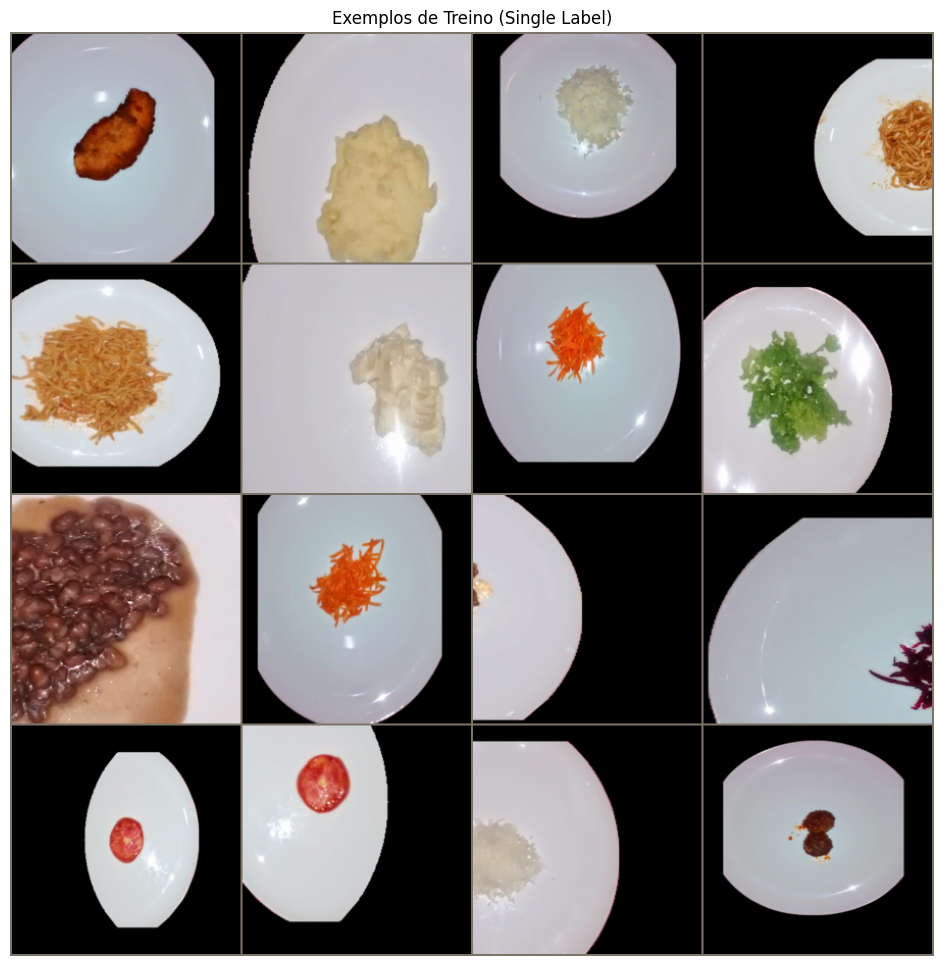

In [4]:
import torchvision
import matplotlib.pyplot as plt

def visualizar_batch(loader, titulo="Amostra do Batch"):
    imagens, labels = next(iter(loader))
    
    grid = torchvision.utils.make_grid(imagens[:16], nrow=4)
    
    plt.figure(figsize=(12, 12))
    plt.title(titulo)
    imshow_tensor(grid) 
    plt.show()

print("Visualizando dados de treino Single-Label (com Augmentation):")
visualizar_batch(train_loader_single, "Exemplos de Treino (Single Label)")

## Célula 5: Treinamento Single-Label (Fine-Tuning)
Configuração e loop de treinamento do modelo base:
1.  **Modelo:** Instancia uma **ResNet18** pré-treinada na ImageNet. Substituímos a última camada (`fc`) para ter o número de neurônios igual ao nosso número de classes de alimentos.
2.  **Otimização:**
    * **Loss:** `CrossEntropyLoss` (adequada para classificação multiclasse onde cada imagem tem apenas um rótulo correto).
    * **Otimizador:** `Adam` com learning rate de `1e-4`, atualizando os pesos de toda a rede (Fine-Tuning).
3.  **Loop de Treino:**
    * Executa por 100 épocas.
    * Monitora a perda (Loss) e acurácia de treino e validação.
    * **Checkpoint:** Salva o modelo (`best_single.pth`) sempre que a acurácia de validação supera a melhor anterior.
    * Ao final, gera gráficos de aprendizado e avalia o modelo no conjunto de teste.

C:\Users\giova\AppData\Roaming\Python\Python313\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\giova\AppData\Roaming\Python\Python313\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Train single epoch 1/100: 100%|██████████| 101/101 [01:04<00:00,  1.57it/s]


Epoch 1 train_loss 0.9630 train_acc 0.7587 | val_loss 0.0498 val_acc 0.9950


Train single epoch 2/100: 100%|██████████| 101/101 [01:01<00:00,  1.64it/s]


Epoch 2 train_loss 0.3530 train_acc 0.9136 | val_loss 0.0213 val_acc 1.0000


Train single epoch 3/100: 100%|██████████| 101/101 [01:04<00:00,  1.56it/s]


Epoch 3 train_loss 0.3487 train_acc 0.9005 | val_loss 0.0125 val_acc 1.0000


Train single epoch 4/100: 100%|██████████| 101/101 [01:01<00:00,  1.64it/s]


Epoch 4 train_loss 0.2732 train_acc 0.9216 | val_loss 0.0195 val_acc 0.9950


Train single epoch 5/100: 100%|██████████| 101/101 [01:02<00:00,  1.62it/s]


Epoch 5 train_loss 0.2858 train_acc 0.9185 | val_loss 0.0073 val_acc 1.0000


Train single epoch 6/100: 100%|██████████| 101/101 [01:06<00:00,  1.52it/s]


Epoch 6 train_loss 0.2336 train_acc 0.9366 | val_loss 0.0067 val_acc 1.0000


Train single epoch 7/100: 100%|██████████| 101/101 [01:00<00:00,  1.67it/s]


Epoch 7 train_loss 0.2648 train_acc 0.9198 | val_loss 0.0025 val_acc 1.0000


Train single epoch 8/100: 100%|██████████| 101/101 [01:01<00:00,  1.65it/s]


Epoch 8 train_loss 0.2468 train_acc 0.9297 | val_loss 0.0068 val_acc 0.9950


Train single epoch 9/100: 100%|██████████| 101/101 [01:02<00:00,  1.62it/s]


Epoch 9 train_loss 0.2339 train_acc 0.9310 | val_loss 0.0017 val_acc 1.0000


Train single epoch 10/100: 100%|██████████| 101/101 [01:01<00:00,  1.63it/s]


Epoch 10 train_loss 0.2187 train_acc 0.9347 | val_loss 0.0027 val_acc 1.0000


Train single epoch 11/100: 100%|██████████| 101/101 [01:02<00:00,  1.63it/s]


Epoch 11 train_loss 0.2128 train_acc 0.9359 | val_loss 0.0375 val_acc 0.9900


Train single epoch 12/100: 100%|██████████| 101/101 [01:01<00:00,  1.63it/s]


Epoch 12 train_loss 0.1843 train_acc 0.9459 | val_loss 0.0011 val_acc 1.0000


Train single epoch 13/100: 100%|██████████| 101/101 [01:02<00:00,  1.61it/s]


Epoch 13 train_loss 0.2360 train_acc 0.9272 | val_loss 0.0086 val_acc 0.9950


Train single epoch 14/100: 100%|██████████| 101/101 [01:04<00:00,  1.56it/s]


Epoch 14 train_loss 0.2059 train_acc 0.9366 | val_loss 0.0022 val_acc 1.0000


Train single epoch 15/100: 100%|██████████| 101/101 [01:09<00:00,  1.45it/s]


Epoch 15 train_loss 0.2086 train_acc 0.9366 | val_loss 0.0167 val_acc 0.9900


Train single epoch 16/100: 100%|██████████| 101/101 [01:00<00:00,  1.68it/s]


Epoch 16 train_loss 0.2273 train_acc 0.9285 | val_loss 0.0009 val_acc 1.0000


Train single epoch 17/100: 100%|██████████| 101/101 [01:03<00:00,  1.60it/s]


Epoch 17 train_loss 0.2136 train_acc 0.9297 | val_loss 0.0015 val_acc 1.0000


Train single epoch 18/100: 100%|██████████| 101/101 [01:09<00:00,  1.46it/s]


Epoch 18 train_loss 0.2368 train_acc 0.9303 | val_loss 0.0317 val_acc 0.9900


Train single epoch 19/100: 100%|██████████| 101/101 [01:04<00:00,  1.56it/s]


Epoch 19 train_loss 0.2018 train_acc 0.9391 | val_loss 0.0025 val_acc 1.0000


Train single epoch 20/100: 100%|██████████| 101/101 [01:08<00:00,  1.47it/s]


Epoch 20 train_loss 0.1610 train_acc 0.9478 | val_loss 0.0125 val_acc 0.9950


Train single epoch 21/100: 100%|██████████| 101/101 [01:08<00:00,  1.48it/s]


Epoch 21 train_loss 0.2154 train_acc 0.9372 | val_loss 0.0012 val_acc 1.0000


Train single epoch 22/100: 100%|██████████| 101/101 [01:08<00:00,  1.48it/s]


Epoch 22 train_loss 0.1885 train_acc 0.9347 | val_loss 0.0009 val_acc 1.0000


Train single epoch 23/100: 100%|██████████| 101/101 [01:07<00:00,  1.50it/s]


Epoch 23 train_loss 0.1909 train_acc 0.9422 | val_loss 0.0004 val_acc 1.0000


Train single epoch 24/100: 100%|██████████| 101/101 [01:07<00:00,  1.50it/s]


Epoch 24 train_loss 0.1869 train_acc 0.9403 | val_loss 0.0002 val_acc 1.0000


Train single epoch 25/100: 100%|██████████| 101/101 [01:04<00:00,  1.57it/s]


Epoch 25 train_loss 0.1706 train_acc 0.9428 | val_loss 0.0094 val_acc 0.9950


Train single epoch 26/100: 100%|██████████| 101/101 [01:17<00:00,  1.31it/s]


Epoch 26 train_loss 0.1813 train_acc 0.9378 | val_loss 0.0029 val_acc 1.0000


Train single epoch 27/100: 100%|██████████| 101/101 [01:03<00:00,  1.59it/s]


Epoch 27 train_loss 0.1981 train_acc 0.9366 | val_loss 0.0066 val_acc 0.9950


Train single epoch 28/100: 100%|██████████| 101/101 [01:10<00:00,  1.43it/s]


Epoch 28 train_loss 0.2165 train_acc 0.9291 | val_loss 0.0076 val_acc 1.0000


Train single epoch 29/100: 100%|██████████| 101/101 [01:05<00:00,  1.55it/s]


Epoch 29 train_loss 0.1650 train_acc 0.9453 | val_loss 0.0008 val_acc 1.0000


Train single epoch 30/100: 100%|██████████| 101/101 [01:05<00:00,  1.54it/s]


Epoch 30 train_loss 0.1653 train_acc 0.9496 | val_loss 0.0002 val_acc 1.0000


Train single epoch 31/100: 100%|██████████| 101/101 [01:11<00:00,  1.41it/s]


Epoch 31 train_loss 0.2044 train_acc 0.9335 | val_loss 0.0012 val_acc 1.0000


Train single epoch 32/100: 100%|██████████| 101/101 [01:03<00:00,  1.60it/s]


Epoch 32 train_loss 0.1964 train_acc 0.9372 | val_loss 0.0187 val_acc 0.9950


Train single epoch 33/100: 100%|██████████| 101/101 [01:04<00:00,  1.57it/s]


Epoch 33 train_loss 0.1944 train_acc 0.9403 | val_loss 0.0009 val_acc 1.0000


Train single epoch 34/100: 100%|██████████| 101/101 [01:09<00:00,  1.46it/s]


Epoch 34 train_loss 0.1761 train_acc 0.9378 | val_loss 0.0007 val_acc 1.0000


Train single epoch 35/100: 100%|██████████| 101/101 [01:08<00:00,  1.48it/s]


Epoch 35 train_loss 0.1611 train_acc 0.9471 | val_loss 0.0006 val_acc 1.0000


Train single epoch 36/100: 100%|██████████| 101/101 [01:06<00:00,  1.53it/s]


Epoch 36 train_loss 0.1670 train_acc 0.9459 | val_loss 0.0008 val_acc 1.0000


Train single epoch 37/100: 100%|██████████| 101/101 [01:02<00:00,  1.63it/s]


Epoch 37 train_loss 0.1612 train_acc 0.9490 | val_loss 0.0005 val_acc 1.0000


Train single epoch 38/100: 100%|██████████| 101/101 [01:03<00:00,  1.60it/s]


Epoch 38 train_loss 0.1445 train_acc 0.9509 | val_loss 0.0006 val_acc 1.0000


Train single epoch 39/100: 100%|██████████| 101/101 [01:01<00:00,  1.65it/s]


Epoch 39 train_loss 0.1744 train_acc 0.9459 | val_loss 0.0005 val_acc 1.0000


Train single epoch 40/100: 100%|██████████| 101/101 [01:00<00:00,  1.66it/s]


Epoch 40 train_loss 0.1856 train_acc 0.9428 | val_loss 0.0011 val_acc 1.0000


Train single epoch 41/100: 100%|██████████| 101/101 [01:08<00:00,  1.47it/s]


Epoch 41 train_loss 0.1860 train_acc 0.9409 | val_loss 0.0004 val_acc 1.0000


Train single epoch 42/100: 100%|██████████| 101/101 [01:05<00:00,  1.54it/s]


Epoch 42 train_loss 0.1840 train_acc 0.9422 | val_loss 0.0004 val_acc 1.0000


Train single epoch 43/100: 100%|██████████| 101/101 [01:03<00:00,  1.58it/s]


Epoch 43 train_loss 0.1569 train_acc 0.9521 | val_loss 0.0014 val_acc 1.0000


Train single epoch 44/100: 100%|██████████| 101/101 [01:06<00:00,  1.52it/s]


Epoch 44 train_loss 0.1481 train_acc 0.9509 | val_loss 0.0071 val_acc 1.0000


Train single epoch 45/100: 100%|██████████| 101/101 [01:13<00:00,  1.38it/s]


Epoch 45 train_loss 0.1752 train_acc 0.9428 | val_loss 0.0022 val_acc 1.0000


Train single epoch 46/100: 100%|██████████| 101/101 [01:00<00:00,  1.66it/s]


Epoch 46 train_loss 0.1481 train_acc 0.9534 | val_loss 0.0092 val_acc 0.9950


Train single epoch 47/100: 100%|██████████| 101/101 [01:01<00:00,  1.63it/s]


Epoch 47 train_loss 0.1585 train_acc 0.9496 | val_loss 0.0003 val_acc 1.0000


Train single epoch 48/100: 100%|██████████| 101/101 [01:14<00:00,  1.36it/s]


Epoch 48 train_loss 0.1863 train_acc 0.9391 | val_loss 0.0001 val_acc 1.0000


Train single epoch 49/100: 100%|██████████| 101/101 [01:18<00:00,  1.28it/s]


Epoch 49 train_loss 0.1760 train_acc 0.9440 | val_loss 0.0004 val_acc 1.0000


Train single epoch 50/100: 100%|██████████| 101/101 [01:02<00:00,  1.62it/s]


Epoch 50 train_loss 0.1741 train_acc 0.9422 | val_loss 0.0004 val_acc 1.0000


Train single epoch 51/100: 100%|██████████| 101/101 [01:02<00:00,  1.61it/s]


Epoch 51 train_loss 0.1392 train_acc 0.9571 | val_loss 0.0024 val_acc 1.0000


Train single epoch 52/100: 100%|██████████| 101/101 [01:04<00:00,  1.57it/s]


Epoch 52 train_loss 0.1400 train_acc 0.9540 | val_loss 0.0055 val_acc 0.9950


Train single epoch 53/100: 100%|██████████| 101/101 [01:04<00:00,  1.57it/s]


Epoch 53 train_loss 0.1699 train_acc 0.9447 | val_loss 0.0312 val_acc 0.9900


Train single epoch 54/100: 100%|██████████| 101/101 [01:03<00:00,  1.58it/s]


Epoch 54 train_loss 0.1428 train_acc 0.9509 | val_loss 0.0078 val_acc 0.9950


Train single epoch 55/100: 100%|██████████| 101/101 [01:07<00:00,  1.50it/s]


Epoch 55 train_loss 0.1181 train_acc 0.9621 | val_loss 0.0060 val_acc 0.9950


Train single epoch 56/100: 100%|██████████| 101/101 [01:06<00:00,  1.53it/s]


Epoch 56 train_loss 0.1552 train_acc 0.9509 | val_loss 0.0004 val_acc 1.0000


Train single epoch 57/100: 100%|██████████| 101/101 [01:07<00:00,  1.50it/s]


Epoch 57 train_loss 0.1894 train_acc 0.9384 | val_loss 0.0003 val_acc 1.0000


Train single epoch 58/100: 100%|██████████| 101/101 [01:00<00:00,  1.66it/s]


Epoch 58 train_loss 0.1578 train_acc 0.9447 | val_loss 0.0004 val_acc 1.0000


Train single epoch 59/100: 100%|██████████| 101/101 [01:00<00:00,  1.67it/s]


Epoch 59 train_loss 0.1273 train_acc 0.9614 | val_loss 0.0002 val_acc 1.0000


Train single epoch 60/100: 100%|██████████| 101/101 [01:00<00:00,  1.66it/s]


Epoch 60 train_loss 0.1356 train_acc 0.9565 | val_loss 0.0011 val_acc 1.0000


Train single epoch 61/100: 100%|██████████| 101/101 [01:01<00:00,  1.64it/s]


Epoch 61 train_loss 0.1152 train_acc 0.9664 | val_loss 0.0077 val_acc 0.9950


Train single epoch 62/100: 100%|██████████| 101/101 [01:07<00:00,  1.50it/s]


Epoch 62 train_loss 0.1347 train_acc 0.9509 | val_loss 0.0006 val_acc 1.0000


Train single epoch 63/100: 100%|██████████| 101/101 [01:00<00:00,  1.68it/s]


Epoch 63 train_loss 0.1492 train_acc 0.9490 | val_loss 0.0066 val_acc 1.0000


Train single epoch 64/100: 100%|██████████| 101/101 [01:07<00:00,  1.50it/s]


Epoch 64 train_loss 0.1481 train_acc 0.9484 | val_loss 0.0002 val_acc 1.0000


Train single epoch 65/100: 100%|██████████| 101/101 [01:04<00:00,  1.57it/s]


Epoch 65 train_loss 0.1153 train_acc 0.9608 | val_loss 0.0003 val_acc 1.0000


Train single epoch 66/100: 100%|██████████| 101/101 [01:09<00:00,  1.45it/s]


Epoch 66 train_loss 0.1469 train_acc 0.9521 | val_loss 0.0007 val_acc 1.0000


Train single epoch 67/100: 100%|██████████| 101/101 [01:11<00:00,  1.40it/s]


Epoch 67 train_loss 0.1344 train_acc 0.9521 | val_loss 0.0005 val_acc 1.0000


Train single epoch 68/100: 100%|██████████| 101/101 [01:07<00:00,  1.49it/s]


Epoch 68 train_loss 0.1688 train_acc 0.9434 | val_loss 0.0006 val_acc 1.0000


Train single epoch 69/100: 100%|██████████| 101/101 [01:02<00:00,  1.61it/s]


Epoch 69 train_loss 0.1206 train_acc 0.9633 | val_loss 0.0005 val_acc 1.0000


Train single epoch 70/100: 100%|██████████| 101/101 [01:01<00:00,  1.63it/s]


Epoch 70 train_loss 0.1203 train_acc 0.9646 | val_loss 0.0001 val_acc 1.0000


Train single epoch 71/100: 100%|██████████| 101/101 [01:03<00:00,  1.60it/s]


Epoch 71 train_loss 0.1312 train_acc 0.9590 | val_loss 0.0010 val_acc 1.0000


Train single epoch 72/100: 100%|██████████| 101/101 [01:03<00:00,  1.59it/s]


Epoch 72 train_loss 0.1436 train_acc 0.9496 | val_loss 0.0025 val_acc 1.0000


Train single epoch 73/100: 100%|██████████| 101/101 [01:03<00:00,  1.60it/s]


Epoch 73 train_loss 0.1365 train_acc 0.9540 | val_loss 0.0007 val_acc 1.0000


Train single epoch 74/100: 100%|██████████| 101/101 [01:04<00:00,  1.57it/s]


Epoch 74 train_loss 0.1447 train_acc 0.9552 | val_loss 0.0004 val_acc 1.0000


Train single epoch 75/100: 100%|██████████| 101/101 [01:15<00:00,  1.34it/s]


Epoch 75 train_loss 0.1403 train_acc 0.9558 | val_loss 0.0002 val_acc 1.0000


Train single epoch 76/100: 100%|██████████| 101/101 [01:04<00:00,  1.56it/s]


Epoch 76 train_loss 0.1420 train_acc 0.9534 | val_loss 0.0202 val_acc 0.9950


Train single epoch 77/100: 100%|██████████| 101/101 [01:04<00:00,  1.57it/s]


Epoch 77 train_loss 0.1187 train_acc 0.9596 | val_loss 0.0003 val_acc 1.0000


Train single epoch 78/100: 100%|██████████| 101/101 [01:04<00:00,  1.58it/s]


Epoch 78 train_loss 0.1413 train_acc 0.9552 | val_loss 0.0005 val_acc 1.0000


Train single epoch 79/100: 100%|██████████| 101/101 [01:10<00:00,  1.44it/s]


Epoch 79 train_loss 0.1479 train_acc 0.9515 | val_loss 0.0004 val_acc 1.0000


Train single epoch 80/100: 100%|██████████| 101/101 [01:07<00:00,  1.49it/s]


Epoch 80 train_loss 0.1345 train_acc 0.9565 | val_loss 0.0011 val_acc 1.0000


Train single epoch 81/100: 100%|██████████| 101/101 [01:11<00:00,  1.40it/s]


Epoch 81 train_loss 0.1424 train_acc 0.9546 | val_loss 0.0003 val_acc 1.0000


Train single epoch 82/100: 100%|██████████| 101/101 [01:05<00:00,  1.55it/s]


Epoch 82 train_loss 0.1454 train_acc 0.9490 | val_loss 0.0008 val_acc 1.0000


Train single epoch 83/100: 100%|██████████| 101/101 [01:02<00:00,  1.61it/s]


Epoch 83 train_loss 0.1596 train_acc 0.9465 | val_loss 0.0046 val_acc 1.0000


Train single epoch 84/100: 100%|██████████| 101/101 [01:09<00:00,  1.45it/s]


Epoch 84 train_loss 0.1240 train_acc 0.9596 | val_loss 0.0005 val_acc 1.0000


Train single epoch 85/100: 100%|██████████| 101/101 [01:04<00:00,  1.56it/s]


Epoch 85 train_loss 0.1464 train_acc 0.9546 | val_loss 0.0004 val_acc 1.0000


Train single epoch 86/100: 100%|██████████| 101/101 [01:08<00:00,  1.48it/s]


Epoch 86 train_loss 0.1430 train_acc 0.9540 | val_loss 0.0027 val_acc 1.0000


Train single epoch 87/100: 100%|██████████| 101/101 [01:08<00:00,  1.47it/s]


Epoch 87 train_loss 0.1017 train_acc 0.9658 | val_loss 0.0004 val_acc 1.0000


Train single epoch 88/100: 100%|██████████| 101/101 [01:09<00:00,  1.46it/s]


Epoch 88 train_loss 0.1246 train_acc 0.9614 | val_loss 0.0001 val_acc 1.0000


Train single epoch 89/100: 100%|██████████| 101/101 [01:06<00:00,  1.52it/s]


Epoch 89 train_loss 0.1402 train_acc 0.9534 | val_loss 0.0000 val_acc 1.0000


Train single epoch 90/100: 100%|██████████| 101/101 [01:00<00:00,  1.67it/s]


Epoch 90 train_loss 0.0967 train_acc 0.9670 | val_loss 0.0002 val_acc 1.0000


Train single epoch 91/100: 100%|██████████| 101/101 [01:01<00:00,  1.64it/s]


Epoch 91 train_loss 0.1469 train_acc 0.9521 | val_loss 0.0000 val_acc 1.0000


Train single epoch 92/100: 100%|██████████| 101/101 [01:00<00:00,  1.67it/s]


Epoch 92 train_loss 0.1118 train_acc 0.9639 | val_loss 0.0046 val_acc 1.0000


Train single epoch 93/100: 100%|██████████| 101/101 [01:09<00:00,  1.46it/s]


Epoch 93 train_loss 0.1088 train_acc 0.9639 | val_loss 0.0004 val_acc 1.0000


Train single epoch 94/100: 100%|██████████| 101/101 [01:04<00:00,  1.57it/s]


Epoch 94 train_loss 0.1256 train_acc 0.9552 | val_loss 0.0002 val_acc 1.0000


Train single epoch 95/100: 100%|██████████| 101/101 [01:02<00:00,  1.62it/s]


Epoch 95 train_loss 0.1182 train_acc 0.9571 | val_loss 0.0001 val_acc 1.0000


Train single epoch 96/100: 100%|██████████| 101/101 [01:00<00:00,  1.67it/s]


Epoch 96 train_loss 0.1194 train_acc 0.9608 | val_loss 0.0001 val_acc 1.0000


Train single epoch 97/100: 100%|██████████| 101/101 [01:00<00:00,  1.66it/s]


Epoch 97 train_loss 0.1362 train_acc 0.9546 | val_loss 0.0001 val_acc 1.0000


Train single epoch 98/100: 100%|██████████| 101/101 [01:01<00:00,  1.65it/s]


Epoch 98 train_loss 0.1331 train_acc 0.9546 | val_loss 0.0001 val_acc 1.0000


Train single epoch 99/100: 100%|██████████| 101/101 [01:01<00:00,  1.65it/s]


Epoch 99 train_loss 0.1515 train_acc 0.9502 | val_loss 0.0003 val_acc 1.0000


Train single epoch 100/100: 100%|██████████| 101/101 [01:01<00:00,  1.65it/s]


Epoch 100 train_loss 0.1237 train_acc 0.9546 | val_loss 0.0010 val_acc 1.0000
Single test acc: 0.995049504950495
Single macro precision/recall/f1: 0.9947916666666666 0.996875 0.995680044593088


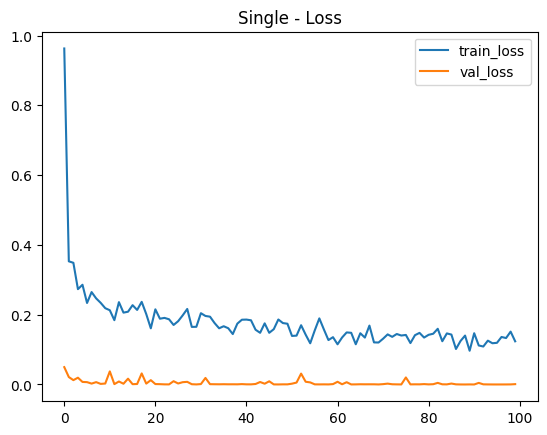

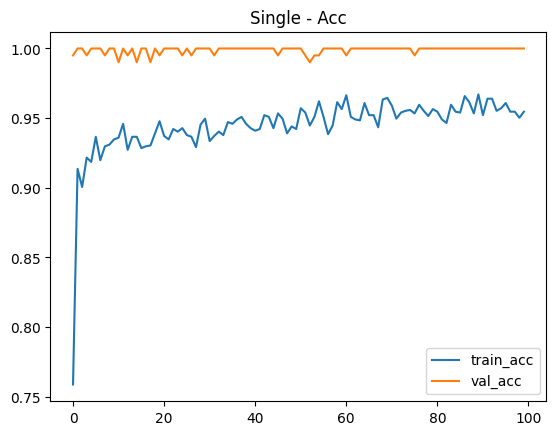

In [5]:
def create_model(num_classes, pretrained=True):
    model = models.resnet18(pretrained=pretrained)
    in_feats = model.fc.in_features
    model.fc = nn.Linear(in_feats, num_classes)
    return model

model_single = create_model(num_classes).to(DEVICE)
criterion_ce = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_single.parameters(), lr=1e-4)

EPOCHS_SINGLE = 100
best_val_acc = 0.0
history_single = {'train_loss':[], 'val_loss':[], 'train_acc':[], 'val_acc':[]}

for epoch in range(EPOCHS_SINGLE):
    model_single.train()
    running_loss = 0.0
    running_corrects = 0
    total = 0
    for inputs, labels in tqdm(train_loader_single, desc=f'Train single epoch {epoch+1}/{EPOCHS_SINGLE}'):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model_single(inputs)
        loss = criterion_ce(outputs, labels)
        loss.backward()
        optimizer.step()
        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data).item()
        total += inputs.size(0)
    train_loss = running_loss / total
    train_acc = running_corrects / total

    model_single.eval()
    val_loss = 0.0
    val_corrects = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in val_loader_single:
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)
            outputs = model_single(inputs)
            loss = criterion_ce(outputs, labels)
            _, preds = torch.max(outputs, 1)
            val_loss += loss.item() * inputs.size(0)
            val_corrects += torch.sum(preds == labels.data).item()
            val_total += inputs.size(0)
    val_loss = val_loss / val_total
    val_acc = val_corrects / val_total

    history_single['train_loss'].append(train_loss)
    history_single['val_loss'].append(val_loss)
    history_single['train_acc'].append(train_acc)
    history_single['val_acc'].append(val_acc)

    print(f'Epoch {epoch+1} train_loss {train_loss:.4f} train_acc {train_acc:.4f} | val_loss {val_loss:.4f} val_acc {val_acc:.4f}')
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model_single.state_dict(), OUTPUT_DIR / 'best_single.pth')

plt.figure(); plt.plot(history_single['train_loss'], label='train_loss'); plt.plot(history_single['val_loss'], label='val_loss'); plt.legend(); plt.title('Single - Loss'); plt.savefig(OUTPUT_DIR/'single_loss.png')
plt.figure(); plt.plot(history_single['train_acc'], label='train_acc'); plt.plot(history_single['val_acc'], label='val_acc'); plt.legend(); plt.title('Single - Acc'); plt.savefig(OUTPUT_DIR/'single_acc.png')

model_single.load_state_dict(torch.load(OUTPUT_DIR/'best_single.pth', map_location=DEVICE))
model_single.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for inputs, labels in test_loader_single:
        inputs = inputs.to(DEVICE)
        outputs = model_single(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(preds.cpu().numpy())

acc = accuracy_score(y_true, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro', zero_division=0)
print('Single test acc:', acc)
print('Single macro precision/recall/f1:', prec, rec, f1)